### Import Dependencies

In [40]:
# importing the necesarry libraries for plotting and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
#importing pytorch for training and testing the model
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [85]:
%load_ext nb_black

ModuleNotFoundError: No module named 'nb_black'

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [111]:
#defining transform to apply on the images, here we have resize, center crop and converting the images to tensor
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor(),transforms.RandomHorizontalFlip()]
)

In [112]:
#defining path to images dataset and applying transform
dataset = datasets.ImageFolder("/home/raccoon/Downloads/data/dataset/Plant_leave_diseases_dataset_with_augmentation", transform=transform)

In [46]:
#checking out dataset
dataset

Dataset ImageFolder
    Number of datapoints: 87196
    Root location: /home/raccoon/Downloads/data/dataset/Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [47]:
#checking out length of indices of the data
indices = list(range(len(dataset)))
indices[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
# 85 percent training data
split = int(np.floor(0.85 * len(dataset)))  # train_size
split

74116

In [48]:
# validation split
validation = int(np.floor(0.70 * split))  # validation
validation

51881

In [49]:
# checking length of train and validation data
print(0, validation, split, len(dataset))

0 51881 74116 87196


In [50]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :51881
length of validation size :22235
length of test size :35315


In [51]:
# shuffling data for randomness
np.random.shuffle(indices)

### Split into Train and Test

In [113]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [14]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [53]:
targets_size = len(dataset.class_to_idx)
targets_size

78

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [52]:
# model = models.vgg16(pretrained=True)

In [53]:
# for params in model.parameters():
#     params.requires_grad = False

In [54]:
# model

In [55]:
# n_features = model.classifier[0].in_features
# n_features

In [56]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [57]:
# model

### Original Modeling

In [155]:
# defining the model class, where K is the output shape, i.e the number of classes that we have in the training images
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            # conv2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            # conv3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            # conv4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            # conv5
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [93]:
# modified
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [92]:
#modified
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [55]:
# device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
device = "cpu"

<IPython.core.display.Javascript object>

In [104]:
#creating an instance of the model
model = CNN(targets_size)

In [105]:
# putting model to device
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inpla

In [28]:
!pip install torchsummary

In [95]:
# checking out summary of the model
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
       BatchNorm2d-6         [-1, 64, 224, 224]             128
         MaxPool2d-7         [-1, 64, 112, 112]               0
           Dropout-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
             ReLU-10        [-1, 128, 112, 112]               0
      BatchNorm2d-11        [-1, 128, 112, 112]             256
           Conv2d-12        [-1, 128, 112, 112]         147,584
             ReLU-13        [-1, 128, 112, 112]               0
      BatchNorm2d-14        [-1, 128, 1

In [32]:
# setting loss and optimzer
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [96]:
#back propagation function
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [97]:

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [98]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 100
)

Epoch : 1/100 Train_loss:2.402 Test_loss:1.897 Duration:0:08:58.606854
Epoch : 2/100 Train_loss:1.543 Test_loss:1.346 Duration:0:08:52.213965
Epoch : 3/100 Train_loss:1.170 Test_loss:1.086 Duration:0:08:50.096050
Epoch : 4/100 Train_loss:0.979 Test_loss:0.941 Duration:0:08:50.391796
Epoch : 5/100 Train_loss:0.852 Test_loss:0.802 Duration:0:08:49.705120
Epoch : 6/100 Train_loss:0.765 Test_loss:0.764 Duration:0:08:53.646556
Epoch : 7/100 Train_loss:0.697 Test_loss:0.740 Duration:0:08:48.989571
Epoch : 8/100 Train_loss:0.648 Test_loss:0.662 Duration:0:08:53.228791
Epoch : 9/100 Train_loss:0.610 Test_loss:0.580 Duration:0:08:50.169166
Epoch : 10/100 Train_loss:0.559 Test_loss:0.548 Duration:0:08:51.836219
Epoch : 11/100 Train_loss:0.540 Test_loss:0.552 Duration:0:08:54.960765
Epoch : 12/100 Train_loss:0.497 Test_loss:0.553 Duration:0:08:51.759844
Epoch : 13/100 Train_loss:0.474 Test_loss:0.475 Duration:0:08:49.570038
Epoch : 14/100 Train_loss:0.450 Test_loss:0.465 Duration:0:08:53.438987
E

### Save the Model

In [99]:
torch.save(model.state_dict() , 'plant_disease_model_100epochs.pt')

In [100]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

### Load Model

In [106]:
state_dict = torch.load("/home/raccoon/Desktop/development/plants/Plant-Disease-Detection/Model/plant_disease_model_100epochs.pt")
model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

In [107]:
targets_size = 78
model = CNN(targets_size)
model.load_state_dict(torch.load("/home/raccoon/Desktop/development/plants/Plant-Disease-Detection/Model/plant_disease_model_100epochs.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inpla

In [ ]:
# %matplotlib notebook

### Plot the loss

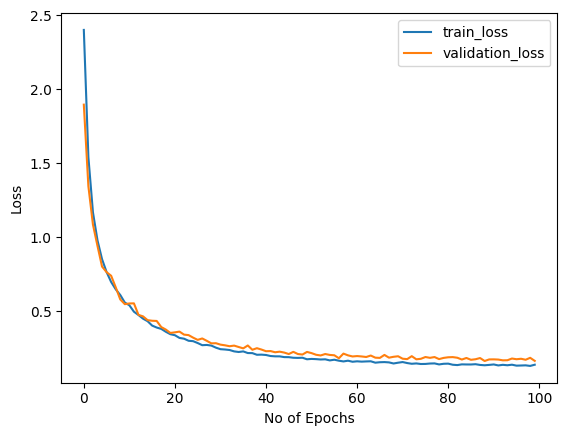

In [108]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [185]:
device='cpu'

In [186]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [187]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [188]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9789711069563038
Test Accuracy : 0.970565749235474
Validation Accuracy : 0.9721610074207331


### Single Image Prediction

In [220]:
transform_index_to_disease = dataset.class_to_idx
transform_index_to_disease

{'Anthracnose': 0,
 'Apple___Apple_scab': 1,
 'Apple___Black_rot': 2,
 'Apple___Cedar_apple_rust': 3,
 'Apple___healthy': 4,
 'Background_without_leaves': 5,
 'Banana___cordana': 6,
 'Banana___healthy': 7,
 'Banana___pestalotiopsis': 8,
 'Banana___sigatoka': 9,
 'Blueberry___healthy': 10,
 'Cherry___Powdery_mildew': 11,
 'Cherry___healthy': 12,
 'Citrus_leaf____Black_spot': 13,
 'Citrus_leaf____Canker': 14,
 'Citrus_leaf____Greening': 15,
 'Citrus_leaf____Healthy': 16,
 'Citrus_leaf____Melanose': 17,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 18,
 'Corn___Common_rust': 19,
 'Corn___Northern_Leaf_Blight': 20,
 'Corn___healthy': 21,
 'Grape___Black_rot': 22,
 'Grape___Esca_(Black_Measles)': 23,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 24,
 'Grape___healthy': 25,
 'Orange___Haunglongbing_(Citrus_greening)': 26,
 'Peach___Bacterial_spot': 27,
 'Peach___healthy': 28,
 'Pepper,_bell___Bacterial_spot': 29,
 'Pepper,_bell___healthy': 30,
 'Potato___Early_blight': 31,
 'Potato___Late_

In [221]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [227]:
transform_index_to_disease[22]

'Grape___Black_rot'

In [228]:
import csv


w = csv.writer(open("output.csv", "w"))

for key, val in transform_index_to_disease.items():

    w.writerow([key, val])

In [192]:
data = pd.read_csv("/home/raccoon/Desktop/development/plants/Plant-Disease-Detection/Flask Deployed App/disease_info.csv", encoding="cp1252")

In [193]:
from PIL import Image
import torchvision.transforms.functional as TF

In [209]:
#improved
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Define the model (assuming it is already loaded and available as 'model')
# Ensure the model is in evaluation mode
model.eval()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def single_prediction(image_path):
    image = Image.open(image_path).convert('RGB')
    
    input_data = transform(image)
    
    input_data = input_data.unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_data)
    
    output = output.numpy()
    
    index = np.argmax(output, axis=1)[0]
    
    disease = transform_index_to_disease[index]
    
    print("Original : ", image_path[12:-4])
    print("Index : ", index)
    print("Predicted : ", disease)




In [195]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [211]:
single_prediction("/home/raccoon/Downloads/data/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Apple___Black_rot/image (2).JPG")

Original :  n/Downloads/data/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Apple___Black_rot/image (2)
Index :  2
Predicted :  Apple___Black_rot


### Wrong Prediction

In [212]:
single_prediction("/home/raccoon/Downloads/data/dataset/Plant_leave_diseases_dataset_with_augmentation/aloe_vera___rot/ro (113).jpg")

Original :  n/Downloads/data/dataset/Plant_leave_diseases_dataset_with_augmentation/aloe_vera___rot/ro (113)
Index :  53
Predicted :  aloe_vera___rot


In [213]:
single_prediction("/home/raccoon/Desktop/development/plants/Plant-Disease-Detection/test_images/tomato_late_blight.JPG")

Original :  n/Desktop/development/plants/Plant-Disease-Detection/test_images/tomato_late_blight
Index :  41
Predicted :  Tomato___Late_blight


In [214]:
single_prediction("/home/raccoon/Desktop/development/plants/Plant-Disease-Detection/test_images/pepper_bacterial_spot.JPG")

Original :  n/Desktop/development/plants/Plant-Disease-Detection/test_images/pepper_bacterial_spot
Index :  29
Predicted :  Pepper,_bell___Bacterial_spot


In [16]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Cherry : Healthy


In [17]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Cherry : Powdery Mildew


In [18]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [19]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [20]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [21]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Corn : Northern Leaf Blight


In [22]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Grape : Black Rot


In [23]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Grape : Healthy


In [24]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Leaf Blight | Isariopsis Leaf Spot


In [25]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Orange : Haunglongbing | Citrus Greening


In [26]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [27]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [28]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Pepper bell : Healthy


In [29]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [30]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Potato : Early Blight


In [31]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Potato : Healthy


In [32]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [33]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [34]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Soybean : Healthy


In [35]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [36]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Squash : Powdery Mildew


In [37]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [38]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [39]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Early Blight


In [40]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Tomato : Early Blight


In [41]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [42]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Late Blight


In [43]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [44]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [45]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [46]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [47]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [48]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus
